

# Homework-3


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,silhouette_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import scipy.stats as stats



In [ ]:
# Define the URL of the raw CSV file on GitHub
url = "https://raw.githubusercontent.com/AysenurYrr/ML-Lab/refs/heads/main/Rain%20in%20Australia/dataset/weatherAUS.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(url, sep=',')

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**About this file**

This dataset contains about 10 years of daily weather observations from numerous Australian weather stations.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No?
This column is Yes if the rain for that day was 1mm or more.

## EDA

In [ ]:
columns_list = df.columns
print(columns_list)

# Create a list to store column details
columns_summary = []

print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')
# Loop through each column and collect its properties
for col in df.columns:
    columns_summary.append({
        'Column Name': col,
        'Number of Unique': df[col].nunique(),
        'Data Type': df[col].dtype,
        'Null Count': df[col].isnull().sum()
    })

# Convert the list into a DataFrame
columns_df = pd.DataFrame(columns_summary)

# Display the DataFrame
print(columns_df)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
Rows: 145460, Columns: 23
      Column Name  Number of Unique Data Type  Null Count
0            Date              3436    object           0
1        Location                49    object           0
2         MinTemp               389   float64        1485
3         MaxTemp               505   float64        1261
4        Rainfall               681   float64        3261
5     Evaporation               358   float64       62790
6        Sunshine               145   float64       69835
7     WindGustDir                16    object       10326
8   WindGustSpeed                67   float64       10263
9      WindDir9am           

In [ ]:
# Find the minimum and maximum values
min_date = df['Date'].min()
max_date = df['Date'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 2007-11-01
Maximum Date: 2017-06-25


satır sayısı 145460 olmasına rağmen aslında bu 145460/365 = 398 yıllık bir veri değildir. Çünkü her Location için ayrı ayrı veriler başa alan Date değerleri vardır.

In [ ]:
# Get the unique values from the Location column
unique_locations = df['Location'].unique().tolist()

print(f"Unique locations: {unique_locations}")

Unique locations: ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine', 'Uluru']


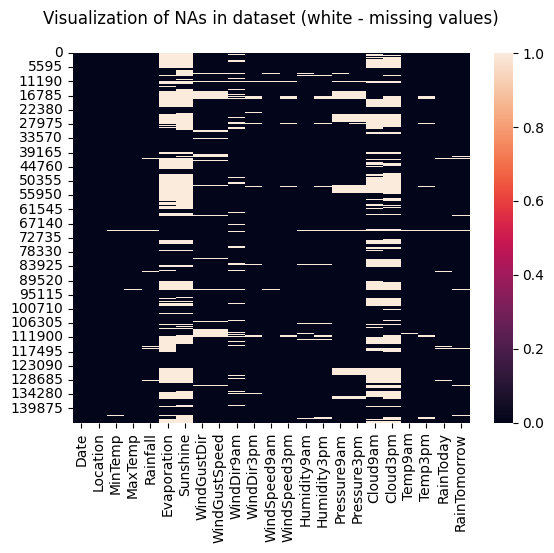

In [ ]:
sns.heatmap(df.isna());
plt.title('Visualization of NAs in dataset (white - missing values)\n');

### Univariate Analysis Handle Missing Target

Upon manually inspecting the data, I observed that when RainTomorrow and RainToday contain NaN values, they are often consecutive. Therefore, it is not feasible to impute RainToday based on RainTomorrow or vice versa. As a result, I decided to remove these rows from the dataset. Since the number of such rows is relatively small, this approach has minimal impact on the overall dataset.

In [ ]:
print("RainTomorrow orginal null", df['RainTomorrow'].isnull().sum())
print("RainTomorrow oroginal nunique",df['RainTomorrow'].nunique())
print("RainTomorrow unique", df['RainTomorrow'].unique())

# Remove rows where RainToday or RainTomorrow contains NaN
df_cleaned = df.dropna(subset=['RainToday', 'RainTomorrow'])

print(f"\nOriginal DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

print("\nRainTomorrow orginal null",df_cleaned['RainTomorrow'].isnull().sum())
print("RainTomorrow oroginal nunique",df_cleaned['RainTomorrow'].nunique())
print("RainTomorrow unique",df_cleaned['RainTomorrow'].unique())

RainTomorrow orginal null 3267
RainTomorrow oroginal nunique 2
RainTomorrow unique ['No' 'Yes' nan]

Original DataFrame shape: (145460, 23)
Cleaned DataFrame shape: (140787, 23)

RainTomorrow orginal null 0
RainTomorrow oroginal nunique 2
RainTomorrow unique ['No' 'Yes']


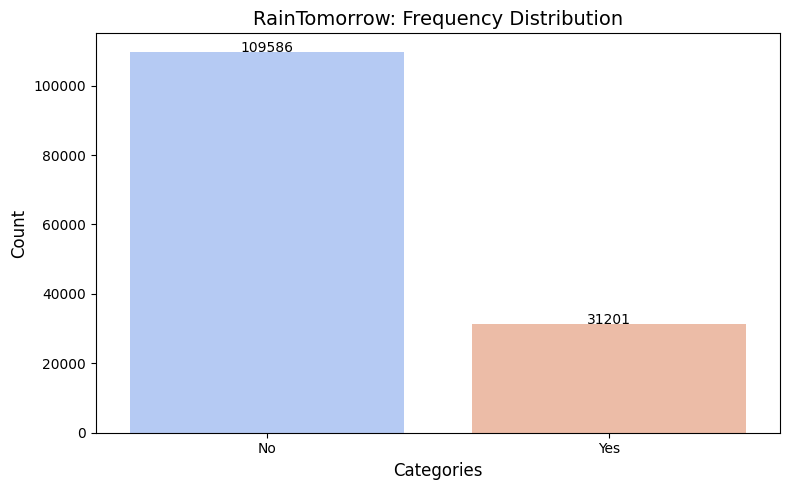

In [ ]:
# Frequency distribution for RainTomorrow
rain_tomorrow_counts = df_cleaned['RainTomorrow'].value_counts()

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(
    x=rain_tomorrow_counts.index,
    y=rain_tomorrow_counts.values,
    palette="coolwarm",
    hue=rain_tomorrow_counts.index,
    dodge=False
)

# Add labels and title
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('RainTomorrow: Frequency Distribution', fontsize=14)

# Annotate exact counts on bars
for i, value in enumerate(rain_tomorrow_counts.values):
    plt.text(i, value + 50, str(value), ha='center', fontsize=10)

# Remove the legend (optional, since it's not needed for this plot)
plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

**Imbalance:**

* The "No" category has significantly more examples compared to the "Yes" category, indicating an imbalanced dataset.
* Count of "No": 109,586
* Count of "Yes": 31,201

**Majority Class:**

* The "No" category represents the majority class and constitutes the larger portion of the dataset.

### Categorical Variables

In [ ]:
categorical = df_cleaned.select_dtypes(include='object').columns.tolist()

print(f'There are {len(categorical)} object type variables\n')
df_cleaned[categorical].head()

# Create a list to store column details
categoric_summary = []

# Loop through each column and collect its properties
for col in df_cleaned[categorical]:
    categoric_summary.append({
        'Column Name': col,
        'Number of Unique': df_cleaned[col].nunique(),
        'Data Type': df_cleaned[col].dtype,
        'Null Count': df_cleaned[col].isnull().sum()
    })

# Convert the list into a DataFrame
columns_df = pd.DataFrame(categoric_summary)

# Display the DataFrame
print(columns_df)


There are 7 object type variables

    Column Name  Number of Unique Data Type  Null Count
0          Date              3436    object           0
1      Location                49    object           0
2   WindGustDir                16    object        9163
3    WindDir9am                16    object        9660
4    WindDir3pm                16    object        3670
5     RainToday                 2    object           0
6  RainTomorrow                 2    object           0


**Categorical Variables Summary**

1. Date Variable:
  * The dataset contains a date variable denoted by the Date column. Although stored in string format, this column represents temporal data and should be treated as a date variable for analysis.

2. Categorical Variables:
  There are 6 categorical variables in the dataset:
  * Location
  * WindGustDir
  * WindDir9am
  * WindDir3pm
  * RainToday
  * RainTomorrow
  > Among these, WindGustDir, WindDir9am, and WindDir3pm contain directional data (e.g., wind directions like N, S, E, W) and are purely categorical.

3. Binary Categorical Variables:
  The dataset includes two binary categorical variables:
  * RainToday: Indicates whether it rained today (Yes/No).
  * RainTomorrow: Indicates whether it is expected to rain tomorrow (Yes/No).
  * RainTomorrow is the target variable for predictive analysis.

4. Wind Direction Variable:
  * WindDir variables (e.g., WindGustDir) are categorical and contain 16 unique directional values without numerical content, confirming their categorical nature.

5. RainTomorrow is the target variable.

### Numeric Values

In [ ]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

print(f'There are {len(numeric_columns)} numeric type variables\n')


# Create a list to store numeric column details
numeric_summary = []

# Loop through each numeric column and collect its properties
for col in numeric_columns:
    numeric_summary.append({
        'Column Name': col,
        'Mean': df[col].mean(),
        'Median': df[col].median(),
        'Standard Deviation': df[col].std(),
        'Minimum Value': df[col].min(),
        'Maximum Value': df[col].max(),
        'Null Count': df[col].isnull().sum()
    })

# Convert the list into a DataFrame
numeric_df = pd.DataFrame(numeric_summary)

# Display the DataFrame
print(numeric_df)


There are 16 numeric type variables

      Column Name         Mean  Median  Standard Deviation  Minimum Value  \
0         MinTemp    12.194034    12.0            6.398495           -8.5   
1         MaxTemp    23.221348    22.6            7.119049           -4.8   
2        Rainfall     2.360918     0.0            8.478060            0.0   
3     Evaporation     5.468232     4.8            4.193704            0.0   
4        Sunshine     7.611178     8.4            3.785483            0.0   
5   WindGustSpeed    40.035230    39.0           13.607062            6.0   
6    WindSpeed9am    14.043426    13.0            8.915375            0.0   
7    WindSpeed3pm    18.662657    19.0            8.809800            0.0   
8     Humidity9am    68.880831    70.0           19.029164            0.0   
9     Humidity3pm    51.539116    52.0           20.795902            0.0   
10    Pressure9am  1017.649940  1017.6            7.106530          980.5   
11    Pressure3pm  1015.255889  1015.2 

## Data PreProcessing

### Handle Categorical Missing Values

I plan to handle the missing values separately for each region because I feel that the wind directions are closely related to the specific characteristics of each region.

In [ ]:
# Create an empty list to store results
location_modes = []

# Iterate over each unique location
for location in unique_locations:
    # Filter the DataFrame for the current location
    location_data = df_cleaned[df_cleaned['Location'] == location]

    # Calculate the mode for each column of interest
    modes = {
        'Location': location,
        'WindGustDir_Mode': location_data['WindGustDir'].mode().iloc[0] if not location_data['WindGustDir'].mode().empty else None,
        'WindDir9am_Mode': location_data['WindDir9am'].mode().iloc[0] if not location_data['WindDir9am'].mode().empty else None,
        'WindDir3pm_Mode': location_data['WindDir3pm'].mode().iloc[0] if not location_data['WindDir3pm'].mode().empty else None
    }

    # Append the results to the list
    location_modes.append(modes)

# Convert the list of dictionaries into a DataFrame
location_modes_df = pd.DataFrame(location_modes)
location_modes_df


,Location,WindGustDir_Mode,WindDir9am_Mode,WindDir3pm_Mode
0,Albury,W,SE,W
1,BadgerysCreek,SW,SW,NNE
2,Cobar,SW,NE,SW
3,CoffsHarbour,NE,SW,NE
4,Moree,NNE,NNE,SW
5,Newcastle,None,NW,SE
6,NorahHead,S,SSW,NE
7,NorfolkIsland,E,E,SE
8,Penrith,SE,SSW,NE
9,Richmond,SE,SSW,NE


In the modes table, we observe that WindGustDir_Mode is None for both Newcastle and Albany. Therefore, I decided to assign the WindDir9am_Mode values corresponding to the same location to the WindGustDir_Mode column for these locations.



In [ ]:
# Update WindGustDir_Mode for Newcastle
location_modes_df.loc[location_modes_df['Location'] == 'Newcastle', 'WindGustDir_Mode'] = 'NW'

# Update WindGustDir_Mode for Albany
location_modes_df.loc[location_modes_df['Location'] == 'Albany', 'WindGustDir_Mode'] = 'NW'
location_modes_df

,Location,WindGustDir_Mode,WindDir9am_Mode,WindDir3pm_Mode
0,Albury,W,SE,W
1,BadgerysCreek,SW,SW,NNE
2,Cobar,SW,NE,SW
3,CoffsHarbour,NE,SW,NE
4,Moree,NNE,NNE,SW
5,Newcastle,NW,NW,SE
6,NorahHead,S,SSW,NE
7,NorfolkIsland,E,E,SE
8,Penrith,SE,SSW,NE
9,Richmond,SE,SSW,NE


In [ ]:
# Fill missing values in df_cleaned based on location_modes_df
for _, row in location_modes_df.iterrows():
    location = row['Location']

    # Fill missing values in WindGustDir
    if pd.notnull(row['WindGustDir_Mode']):
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned['WindGustDir'].isnull()),
            'WindGustDir'
        ] = row['WindGustDir_Mode']

    # Fill missing values in WindDir9am
    if pd.notnull(row['WindDir9am_Mode']):
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned['WindDir9am'].isnull()),
            'WindDir9am'
        ] = row['WindDir9am_Mode']

    # Fill missing values in WindDir3pm
    if pd.notnull(row['WindDir3pm_Mode']):
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned['WindDir3pm'].isnull()),
            'WindDir3pm'
        ] = row['WindDir3pm_Mode']


In [ ]:
df_cleaned[categorical]

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No
...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,E,ESE,E,No,No
145455,2017-06-21,Uluru,E,SE,ENE,No,No
145456,2017-06-22,Uluru,NNW,SE,N,No,No
145457,2017-06-23,Uluru,N,SE,WNW,No,No


### Handle Numerical Missing Values

In [ ]:
# Compute the global mean for numeric columns
global_means = df_cleaned[numeric_columns].mean()

for location in unique_locations:
    # Filter data for the current location
    location_data = df_cleaned[df_cleaned['Location'] == location]

    # Iterate through each numeric column
    for col in numeric_columns:
        # Compute the mode for the current location, ignoring NaN values
        column_mode = location_data[col].mode().iloc[0] if not location_data[col].mode().empty else None

        # Assign value based on mode or mean
        if column_mode == 0 or column_mode is None:  # If mode is 0 or does not exist
            value = location_data[col].mean() if not location_data[col].isnull().all() else global_means[col]
        else:
            value = column_mode

        # Assign the value to NaN cells for the current column and location
        df_cleaned.loc[
            (df_cleaned['Location'] == location) & (df_cleaned[col].isnull()), col] = value

        # Print the assigned value for debugging
        print(f"Location: {location}, Column: {col}, Assigned Value: {value}")

    print("\n")


Location: Albury, Column: MinTemp, Assigned Value: 10.0
Location: Albury, Column: MaxTemp, Assigned Value: 14.9
Location: Albury, Column: Rainfall, Assigned Value: 1.9257104647275156
Location: Albury, Column: Evaporation, Assigned Value: 5.472515506887154
Location: Albury, Column: Sunshine, Assigned Value: 7.630539861047281
Location: Albury, Column: WindGustSpeed, Assigned Value: 24.0
Location: Albury, Column: WindSpeed9am, Assigned Value: 8.219397993311036
Location: Albury, Column: WindSpeed3pm, Assigned Value: 11.0
Location: Albury, Column: Humidity9am, Assigned Value: 100.0
Location: Albury, Column: Humidity3pm, Assigned Value: 47.0
Location: Albury, Column: Pressure9am, Assigned Value: 1018.6
Location: Albury, Column: Pressure3pm, Assigned Value: 1015.6
Location: Albury, Column: Cloud9am, Assigned Value: 8.0
Location: Albury, Column: Cloud3pm, Assigned Value: 8.0
Location: Albury, Column: Temp9am, Assigned Value: 7.6
Location: Albury, Column: Temp3pm, Assigned Value: 14.0


Locatio

This code aims to fill missing values for numeric columns *(numeric_columns)* on a per-location basis. Here's how it works:

1. Calculation of Global Means:
  * Global means *(global_means)* are calculated for all numeric columns. These will serve as fallback values if all data for a specific column in a location is missing.

2. Processing Per Location:
  * For each location in unique_locations, a subset of the data *(location_data)* is created. This subset contains only rows for the current location.

3. Mode and Mean Decision:
  * Mode Calculation: The mode for each column in the current location is computed.
  * If the mode is 0 or does not exist *(None)*, the mean value for the column in that location is used.
  * If the entire column for that location is missing *(NaN)*, the global mean is assigned.

4. Value Assignment and Debugging:
  * Missing values are filled based on the rules above, and an informational message is printed to show the assigned values.

In [ ]:
df_cleaned.head().describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,12.080000,26.800000,0.320000,5.472516,7.630540e+00,39.800000,12.200000,20.200000,56.000000,25.200000,1010.860000,1008.480000,7.800000,6.800000,18.200000,25.100000
std,3.936623,3.570714,0.460435,0.000000,9.930137e-16,9.011104,7.120393,6.648308,19.300259,6.685806,4.065464,2.609023,0.447214,2.683282,1.635543,3.092733
min,7.400000,22.900000,0.000000,5.472516,7.630540e+00,24.000000,4.000000,9.000000,38.000000,16.000000,1007.600000,1006.000000,7.000000,2.000000,16.900000,21.800000
25%,9.200000,25.100000,0.000000,5.472516,7.630540e+00,41.000000,7.000000,20.000000,44.000000,22.000000,1007.700000,1007.100000,8.000000,8.000000,17.200000,23.200000
50%,12.900000,25.700000,0.000000,5.472516,7.630540e+00,44.000000,11.000000,22.000000,45.000000,25.000000,1010.600000,1007.800000,8.000000,8.000000,17.800000,24.300000
75%,13.400000,28.000000,0.600000,5.472516,7.630540e+00,44.000000,19.000000,24.000000,71.000000,30.000000,1010.800000,1008.700000,8.000000,8.000000,18.100000,26.500000
max,17.500000,32.300000,1.000000,5.472516,7.630540e+00,46.000000,20.000000,26.000000,82.000000,33.000000,1017.600000,1012.800000,8.000000,8.000000,21.000000,29.700000


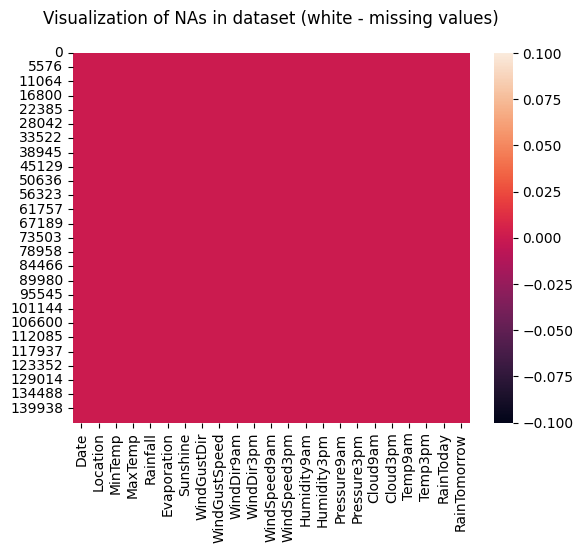

In [ ]:
sns.heatmap(df_cleaned.isna());
plt.title('Visualization of NAs in dataset (white - missing values)\n');

In [ ]:
df_cleaned.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,5.472516,7.63054,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,8.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,5.472516,7.63054,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,8.0,8.0,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,5.472516,7.63054,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,5.472516,7.63054,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,8.0,8.0,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,5.472516,7.63054,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Encoding Categorical Variables




In [ ]:
one_hot = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [ ]:
# Copy the cleaned DataFrame to df_encoded
df_encoded = df_cleaned.copy()

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
one_hot_encoded = one_hot_encoder.fit_transform(df_encoded[one_hot])

# Convert one-hot encoded array to a DataFrame
one_hot_encoded_df = pd.DataFrame(
    one_hot_encoded,
    columns=one_hot_encoder.get_feature_names_out(one_hot)
)

# Reset index to align with df_encoded
one_hot_encoded_df.index = df_encoded.index

# Drop original one-hot columns and concatenate encoded columns
df_encoded.drop(columns=one_hot, inplace=True)
df_encoded = pd.concat([df_encoded, one_hot_encoded_df], axis=1)

# Map "Yes" to 1 and "No" to 0 in RainToday and RainTomorrow
df_encoded['RainToday'] = df_encoded['RainToday'].map({'No': 0, 'Yes': 1})
df_encoded['RainTomorrow'] = df_encoded['RainTomorrow'].map({'No': 0, 'Yes': 1})


# Display updated DataFrame
print(df_encoded.columns)
print(df_encoded.info())
df_encoded.head()


Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE',
       'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S',
       'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW',
       'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,2008-12-01,Albury,13.4,22.9,0.6,5.472516,7.63054,44.0,20.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,5.472516,7.63054,44.0,4.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2008-12-03,Albury,12.9,25.7,0.0,5.472516,7.63054,46.0,19.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2008-12-04,Albury,9.2,28.0,0.0,5.472516,7.63054,24.0,11.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,5.472516,7.63054,41.0,7.0,20.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test Split

The goal is to split the dataset for each unique location into training (80%) and testing (20%) sets sequentially, while preserving the order of the data. This ensures that each location's data is fairly represented in both sets.

In [ ]:
# Store train and test data for all locations
train_data = pd.DataFrame()  # To accumulate training data
test_data = pd.DataFrame()   # To accumulate test dat

# Iterate through each unique location
for location in unique_locations:
    # Filter data for the current location
    location_data = df_encoded[df_encoded['Location'] == location]

    # Determine the split index
    split_index = int(len(location_data) * 0.8)

    # Split data sequentially into train and test sets
    location_train = location_data.iloc[:split_index]
    location_test = location_data.iloc[split_index:]

    # Append to the cumulative train and test datasets
    train_data = pd.concat([train_data, location_train])
    test_data = pd.concat([test_data, location_test])

# Display the sizes of the final datasets
print(f"Train Data Size: {train_data.shape}")
print(f"Test Data Size: {test_data.shape}")


Train Data Size: (112610, 65)
Test Data Size: (28177, 65)


### Data Balance Inner Thoughts

I know that the data is unbalanced, but I believe that in real-life scenarios, my data is naturally unbalanced. This is the inherent nature of the data. I could apply methods like down-sampling or similar techniques to balance it, but doing so would mean losing the natural characteristics of the data. While such methods might result in a higher F1 score, I prefer not to apply them because they would move the data away from its natural state.

### Feature Selection Correlation

Selected Features for Future Use: ['Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'RainToday', 'RainTomorrow']


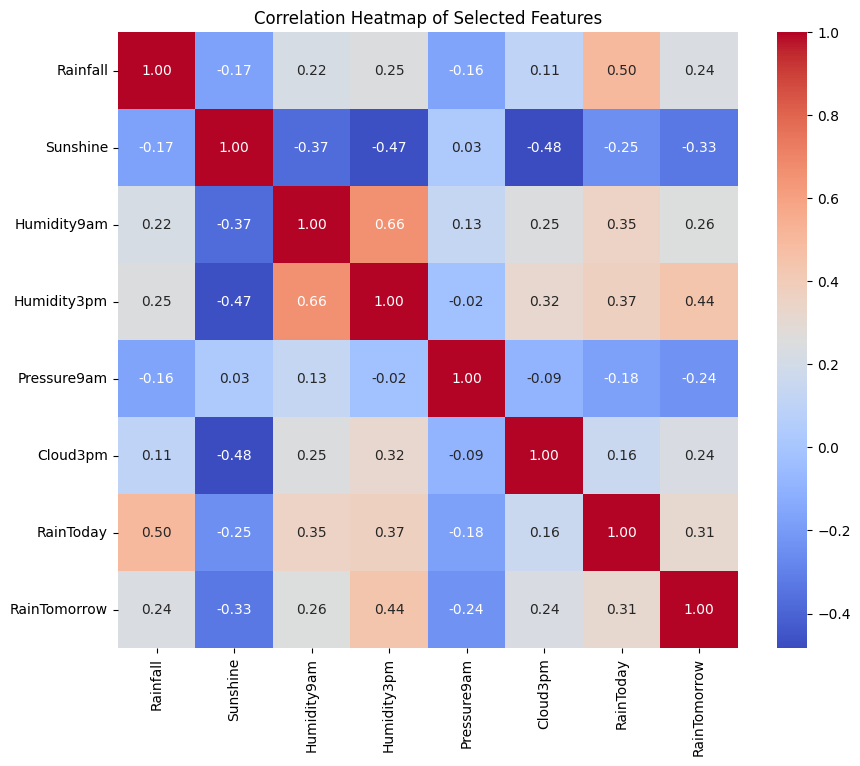

In [ ]:
# Compute the correlation matrix, excluding non-numeric columns like 'Date' and 'Location'
corr = df_encoded.drop(columns=['Date', 'Location']).corr()  # Drop 'Date' and 'Location' columns

threshold = 0.23

# Identify features highly correlated with the target 'RainTomorrow'
condition = np.absolute(corr['RainTomorrow']) > threshold  # Features with absolute correlation > threshold
top_corr = corr.loc[condition, condition]  # Filter only rows and columns that meet the condition
data_top_corr = df_encoded.loc[:, top_corr.columns]  # Select the corresponding columns from the original dataset

# Display the selected features
print("Selected Features for Future Use:", list(data_top_corr.columns))

# Plot a heatmap of the top correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

Strong Positive Correlations:

Humidity3pm has a strong positive correlation (0.44) with RainTomorrow, indicating that higher humidity in the afternoon increases the likelihood of rain the next day.
RainToday has a moderate positive correlation (0.31) with RainTomorrow, meaning rain today increases the chance of rain tomorrow.

In [ ]:
top_corr_features = list(data_top_corr.columns)
top_corr_features.remove('RainTomorrow')
top_corr_features

['Rainfall',
 'Sunshine',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Cloud3pm',
 'RainToday']

In [ ]:
train_X, train_y = train_data.drop('RainTomorrow', axis = 1), train_data['RainTomorrow']
test_X, test_y = test_data.drop('RainTomorrow', axis = 1), test_data['RainTomorrow']

### Scaler

* StandardScaler transforms the data to have a mean of 0 and a standard deviation of 1, which standardizes the distribution while maintaining its Gaussian (normal) shape. This is especially useful if the features follow a normal distribution.
* Algorithms like Logistic Regression, SVM, and KNN are sensitive to feature scaling because they calculate distances or optimize based on gradients. StandardScaler accelerates convergence and improves model stability.

In [ ]:
train_selected_X = train_X[top_corr_features]
test_selected_X = test_X[top_corr_features]
print("Train")
print(train_selected_X.shape)
print(train_y.shape,"\n")
print("Test")
print(test_selected_X.shape)
print(test_y.shape)


Train
(112610, 7)
(112610,) 

Test
(28177, 7)
(28177,)


In [ ]:


scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_selected_X)
test_X_scaled = scaler.transform(test_selected_X)
print("Train")
print(train_X_scaled.shape)
print(train_y.shape,"\n")
print("Test")
print(test_X_scaled.shape)
print(test_y.shape)

Train
(112610, 7)
(112610,) 

Test
(28177, 7)
(28177,)


## Logistic Regression

#### Training

In [ ]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

# Train the model on the scaled training data
logreg.fit(train_X_scaled, train_y)

LogisticRegression(max_iter=1000)

### Evaluation

In [ ]:
# Predict on the test set
y_pred = logreg.predict(test_X_scaled)

# Predict probabilities (if needed for metrics like ROC-AUC)
y_pred_proba = logreg.predict_proba(test_X_scaled)[:, 1]


In [ ]:

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(test_y, y_pred))


Accuracy: 0.8309
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     21905
           1       0.70      0.42      0.52      6272

    accuracy                           0.83     28177
   macro avg       0.78      0.68      0.71     28177
weighted avg       0.82      0.83      0.81     28177



### Hyperparameters Tuning

In [ ]:


# Define the parameter distribution
param_dist = {
    'C': stats.loguniform(0.001, 100),  # Log-uniform distribution for regularization
    'penalty': ['l1', 'l2'],
    'solver': ['saga', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Use RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(estimator=logreg, param_distributions=param_dist, cv=5, scoring='accuracy', n_iter=50, n_jobs=-1, random_state=42)
random_search.fit(train_X_scaled, train_y)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

# Train the best model on the training set
best_model_logreg = random_search.best_estimator_

feature_importance = pd.DataFrame({
    'Feature': train_selected_X.columns,
    'Coefficient': best_model_logreg.coef_[0]  # Logistic Regression coefficients
})


Best Parameters: {'C': 0.0017113085338473892, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8362045999467188


### Feature Importance

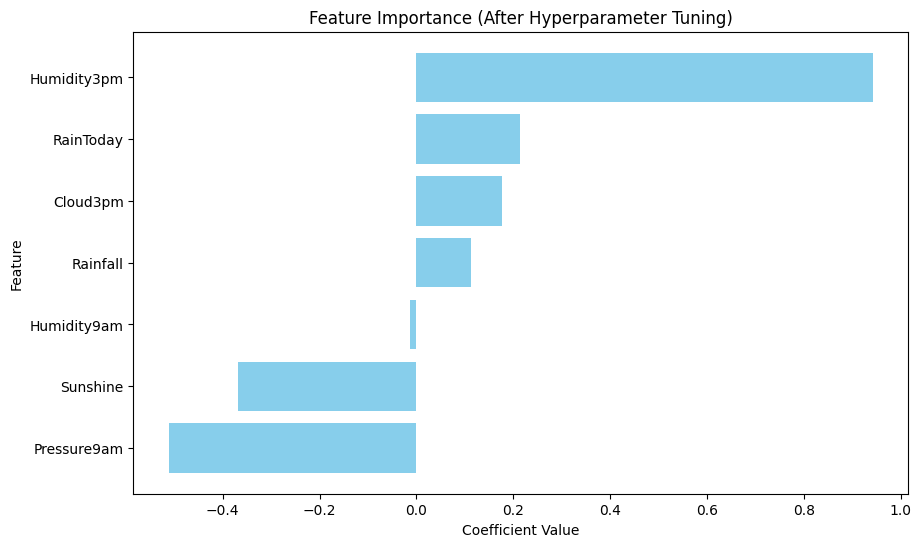

In [ ]:
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.title('Feature Importance (After Hyperparameter Tuning)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


### Final Evulation

In [ ]:
y_pred = best_model_logreg.predict(test_X_scaled)

# Predict probabilities (if needed for metrics like ROC-AUC)
y_pred_proba = best_model_logreg.predict_proba(test_X_scaled)[:, 1]

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(test_y, y_pred))



Accuracy: 0.8314
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     21905
           1       0.71      0.42      0.52      6272

    accuracy                           0.83     28177
   macro avg       0.78      0.68      0.71     28177
weighted avg       0.82      0.83      0.81     28177



### Confusion Matrix

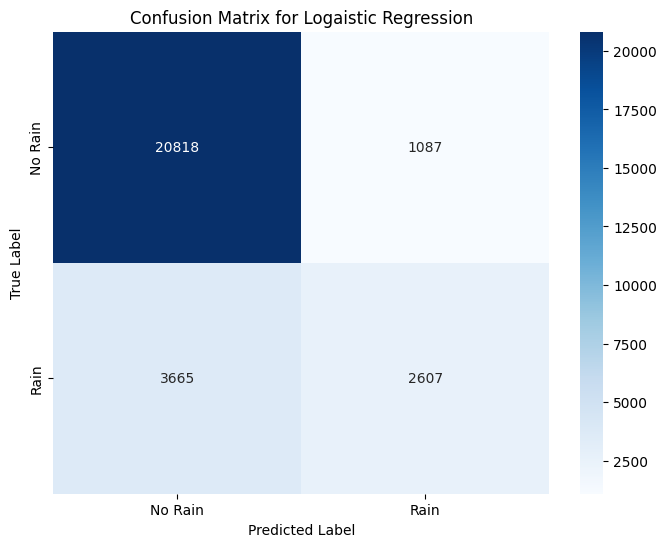

In [ ]:
# Generate the confusion matrix
cm_logreg = confusion_matrix(test_y, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title("Confusion Matrix for Logaistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

LogReg ROC-AUC Score: 0.8280


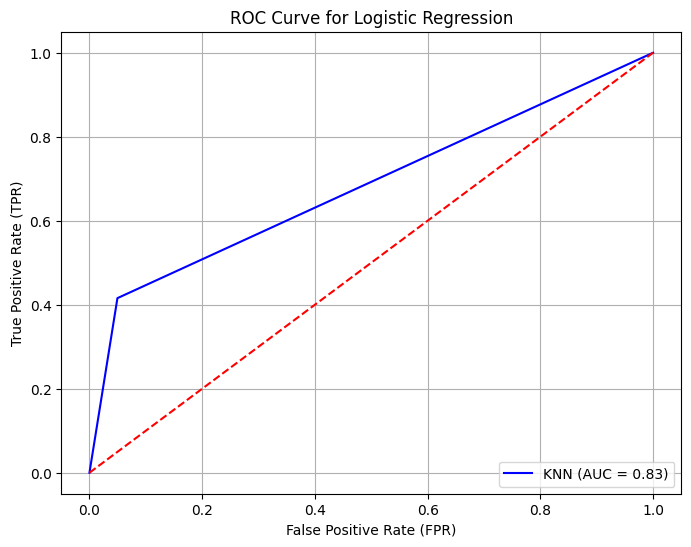

In [ ]:
# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred)

# Calculate AUC Score
logreg_auc = roc_auc_score(test_y, y_pred_proba)
print(f"LogReg ROC-AUC Score: {logreg_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'KNN (AUC = {logreg_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guessing line
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## K-Nearest Neighbors (KNN)

### hyperparameters tuning

In [ ]:


# Range of K values
k_values = [1,3,5,9,13,15,17,21,24,27]  # Test K values
accuracy_scores_knn = []

for k in k_values:
    # Initialize the KNN model with the current K
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X_scaled, train_y)

    # Predict on the test set
    y_pred_knn = knn.predict(test_X_scaled)

    # Evaluate accuracy
    acc = accuracy_score(test_y, y_pred_knn)
    accuracy_scores_knn.append(acc)
    print(f"K={k} - Accuracy: {acc:.4f}")


### How different values of K impacts the metrics were demonstrated

In [ ]:
# Plot accuracy scores for different K values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores_knn, marker='o', linestyle='-', color='b')
plt.title("Effect of K on Accuracy (KNN)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid()
plt.show()


For small values of K (e.g., K = 1 K=1), the accuracy is relatively low ( 0.77 0.77). As K increases, the accuracy improves, stabilizing around K=13 and beyond. The accuracy stabilizes at K = 13. Increasing K further does not significantly improve the accuracy. Larger K values provide more stability but might underfit the data because the predictions are averaged over too many neighbors.



In [ ]:
knn_best_model = KNeighborsClassifier(n_neighbors=13)

# Fit the KNN model on the training data
knn_best_model.fit(train_X_scaled, train_y)

# Predict on the test set
y_pred_knn = knn_best_model.predict(test_X_scaled)
y_pred_proba_knn = knn_best_model.predict_proba(test_X_scaled)[:, 1]  # Get probabilities for the positive class

# Accuracy
knn_accuracy = accuracy_score(test_y, y_pred_knn)
print(f"KNN Accuracy: {knn_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(test_y, y_pred_knn))

### Confusion Matrix


In [ ]:
# Generate the confusion matrix
cm_knn = confusion_matrix(test_y, y_pred_knn)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title("Confusion Matrix for KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

In [ ]:
# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba_knn)

# Calculate AUC Score
knn_auc = roc_auc_score(test_y, y_pred_proba_knn)
print(f"KNN ROC-AUC Score: {knn_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'KNN (AUC = {knn_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve for KNN')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Naive Bayes


### Training Naive Bayes Model

In [ ]:
# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Train the model on the training data
nb_model.fit(train_X_scaled, train_y)


GaussianNB()

### Evulation Naive Bayes Model

In [ ]:
# Predict on the test set
y_pred_nb = nb_model.predict(test_X_scaled)
y_pred_proba_nb = nb_model.predict_proba(test_X_scaled)[:, 1]

# Accuracy
nb_accuracy = accuracy_score(test_y, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(test_y, y_pred_nb))

Naive Bayes Accuracy: 0.8036
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     21905
           1       0.57      0.48      0.52      6272

    accuracy                           0.80     28177
   macro avg       0.71      0.69      0.70     28177
weighted avg       0.79      0.80      0.80     28177



### Hyper Parameter Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)  # Explore values from 1 to 1e-9
}

# Initialize GridSearchCV
grid_search_nb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(train_X_scaled, train_y)

print("Best Parameters for Naive Bayes:", grid_search_nb.best_params_)
print("Accuracy for Naive Bayes:", grid_search_nb.best_score_)

# Train the best model on the training set
best_nb_model = grid_search_nb.best_estimator_


Best Parameters for Naive Bayes: {'var_smoothing': 0.657933224657568}
Accuracy for Naive Bayes: 0.8234526241008793


### Final Evulation using Best Model

In [ ]:
# Predict on the test set using the best model
y_pred_best_nb = best_nb_model.predict(test_X_scaled)
y_pred_proba_best_nb = best_nb_model.predict_proba(test_X_scaled)[:, 1]

# Accuracy
nb_best_accuracy = accuracy_score(test_y, y_pred_best_nb)
print(f"Tuned Naive Bayes Accuracy: {nb_best_accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(test_y, y_pred_nb))

# ROC-AUC Score
nb_auc = roc_auc_score(test_y, y_pred_proba_nb)
print(f"Naive Bayes ROC-AUC Score: {nb_auc:.4f}")


### ROC Curve

KNN ROC-AUC Score: 0.8097


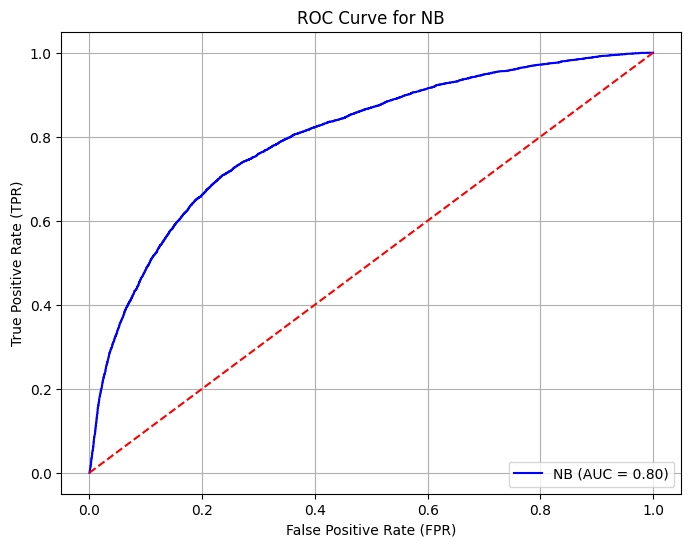

In [ ]:
# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba_best_nb)

# Calculate AUC Score
nb_auc = roc_auc_score(test_y, y_pred_proba_best_nb)
print(f"KNN ROC-AUC Score: {knn_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'NB (AUC = {nb_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve for NB')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## SVM

### Trainin SVM Model

In [ ]:
# Resample the training set (e.g., use 20% of the data)
X_train_resampled, _, y_train_resampled, _ = train_test_split(
    train_X_scaled, train_y, test_size=0.8, stratify=train_y, random_state=42
)

i resambled training dataset because of SVM cant fit large dataset

In [ ]:
# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)  # Enable probability=True for ROC-AUC

# Train the model on the training data
svm_model.fit(X_train_resampled, y_train_resampled)

SVC(probability=True, random_state=42)

### Evulation

In [ ]:
# Predict on the test set
y_pred_svm = svm_model.predict(X_train_resampled)
y_pred_proba_svm = svm_model.predict_proba(X_train_resampled)[:, 1]  # For ROC-AUC

# Accuracy
svm_accuracy = accuracy_score(y_train_resampled, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_train_resampled, y_pred_svm))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_train_resampled, y_pred_svm))


SVM Accuracy: 0.8416
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     17536
           1       0.76      0.42      0.54      4986

    accuracy                           0.84     22522
   macro avg       0.81      0.69      0.72     22522
weighted avg       0.83      0.84      0.82     22522

Confusion Matrix:
[[16864   672]
 [ 2896  2090]]


### Hyper Parameter Optimization

In [ ]:
# Define the parameter distribution
param_dist = {
    'C': np.logspace(-2, 1, 4),
    'kernel': ['linear', 'rbf'],
}

# Perform RandomizedSearchCV
random_search_svm = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=4,  # Number of iterations
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2  # Display detailed output for each iteration
)

# Fit the randomized search to the training data
random_search_svm.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and cross-validation accuracy
print("Best Parameters for SVM:", random_search_svm.best_params_)
print("Best Cross-Validation Accuracy for SVM:", random_search_svm.best_score_)

# Train the best model
best_svm_model = random_search_svm.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters for SVM: {'kernel': 'rbf', 'C': 1.0}
Best Cross-Validation Accuracy for SVM: 0.8377141377335692


### Final Evulation

In [ ]:
y_pred_svm = best_model_logreg.predict(test_X_scaled)
y_pred_proba_best_svm = best_nb_model.predict_proba(test_X_scaled)[:, 1]

# Accuracy
svm_best_accuracy = accuracy_score(test_y, y_pred_svm)
print(f"Tuned SVM Accuracy: {svm_best_accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(test_y, y_pred_svm))


# Classification Report
print(" SVM Classification Report:")
print(classification_report(test_y, y_pred_svm))

# ROC-AUC Score
nb_auc = roc_auc_score(test_y, y_pred_proba_best_svm)
print(f"SVM ROC-AUC Score: {nb_auc:.4f}")

Tuned SVM Accuracy: 0.8314
Confusion Matrix:
[[20818  1087]
 [ 3665  2607]]
 SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     21905
           1       0.71      0.42      0.52      6272

    accuracy                           0.83     28177
   macro avg       0.78      0.68      0.71     28177
weighted avg       0.82      0.83      0.81     28177

SVM ROC-AUC Score: 0.8012


### Confusion Matrix

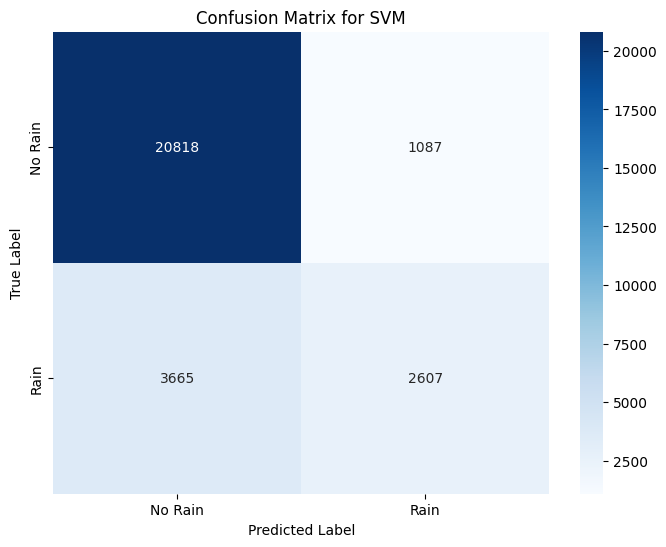

In [ ]:
# Generate the confusion matrix
svm_knn = confusion_matrix(test_y, y_pred_svm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(svm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title("Confusion Matrix for SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

SVM ROC-AUC Score: 0.6830


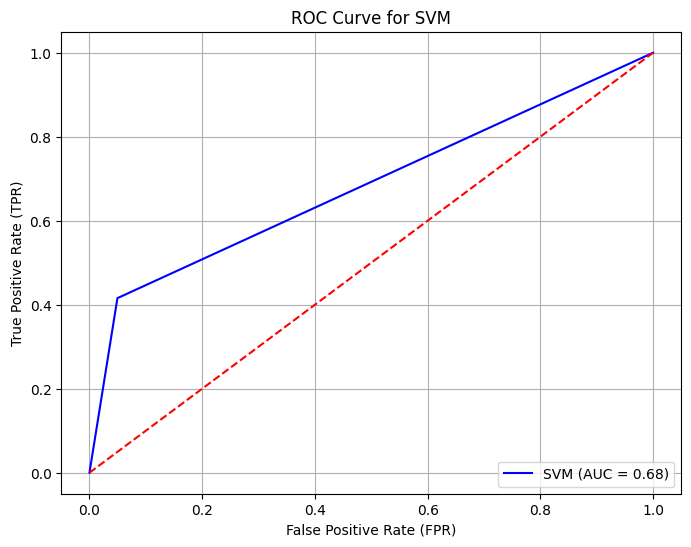

In [ ]:
# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred_svm)

# Calculate AUC Score
svm_roc = roc_auc_score(test_y, y_pred_svm)
print(f"SVM ROC-AUC Score: {svm_roc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'SVM (AUC = {svm_roc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guessing line
plt.title('ROC Curve for SVM')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Conculusion

In [ ]:
table = {
    "Algorithm": ["Logistic Regression", "KNN", "Naive Bayes", "SVM"],
    "Accuracy": [0.8314, 0.8291, 0.8141, 0.8314],
    "ROC-AUC Score": [0.83, 0.81, 0.69, 0.8012],
    "Positive Class (F1)": [0.52, 0.52, 0.50, 0.52],
    "Negative Class (F1)": [0.90, 0.90, 0.90, 0.90],
}

table_df = pd.DataFrame(table)

from IPython.display import display
display(table_df)


,Algorithm,Accuracy,ROC-AUC Score,Positive Class (F1),Negative Class (F1)
0,Logistic Regression,0.8314,0.8300,0.52,0.9
1,KNN,0.8291,0.8100,0.52,0.9
2,Naive Bayes,0.8141,0.6900,0.50,0.9
3,SVM,0.8314,0.8012,0.52,0.9


Logistic Regression: The best-performing algorithm overall, with high accuracy and ROC-AUC. It showed relatively balanced performance across both classes compared to other algorithms.
KNN: Achieved similar accuracy to Logistic Regression but lagged in ROC-AUC and positive class performance.
Naive Bayes: While simple and efficient, it underperformed in both accuracy and ROC-AUC metrics.
SVM: Showed weak performance in ROC-AUC and positive class F1 score, making it less favorable than Logistic Regression and KNN.